In [1]:
import obspy
import numpy as np
import matplotlib.pyplot as plt
from copy import copy

file_path = 'UT.STN12.A2_C50.miniseed'

# Membaca data MiniSEED 
st = obspy.read(file_path)
#prepro sederhana
sta = st.detrend("linear")
tr_copy = sta.copy()
tr_copy.filter('bandpass', freqmin= 0.1, freqmax= 5, corners=4, zerophase=True)
#st.plot()
# Memecah komponen X, Y, dan Z
trace_x = tr_copy.select(channel="*N")[0]
trace_y = tr_copy.select(channel="*E")[0]
trace_z = tr_copy.select(channel="*Z")[0]
print(trace_x)

UT.STN12..BHN | 2017-05-04T05:30:00.000000Z - 2017-05-04T06:00:00.000000Z | 100.0 Hz, 180001 samples


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from obspy.core import UTCDateTime
class hvsr:
    def __init__(self, trace_n, trace_w, trace_v, size):
        self.trace_n = trace_n
        self.trace_w = trace_w
        self.trace_v = trace_v
        self.size = size
    
    def time(self, trace):
        self.trace = trace
        start = self.trace.stats.starttime
        end = self.trace.stats.endtime
        #pembuatan table
        self.df = pd.DataFrame(columns=['start','end'])
        i = 0
        #untuk membatasi pembuatan table time
        while start + i * self.size < end:
            #pembuatan range waktu window
            self.df = pd.concat([self.df, pd.DataFrame({'start': start + i * self.size,'end': 
                min(start + (i + 1) * self.size, end)}, index=[0])], ignore_index=True)  # noqa: E501
            i += 1
        
    def window(self,trace):
        self.result = []
        #pembacaan table untuk diambil isi table yang berupa range window
        for _, row in self.df.iterrows():
            st = UTCDateTime(row['start'])
            en = UTCDateTime(row['end'])
            if st != en:
                #membuat perulangan untuk memotong trace
                trim = trace.slice(st, en)
                if len(trim) > 0:
                    self.result.append(trim)
        print(self.result[0])
        return self.result

    def fft(self, window):
        res_win = window
        fft_res = []
        #perulangan fft
        for i in range(len(res_win)):
            fft = np.fft.fft(res_win[i])
            fft_res.append(fft)
        return fft_res
    
    def get_freq(self, win, spec):
        for i in range(len(win)):
            sampling_rate = win[i].stats.sampling_rate
            npts = win[i].stats.npts
            #print(len(spec[0]))
            freq = np.fft.fftfreq(npts, d=1/sampling_rate)
            x = freq[:int(npts/2)]
            plt.plot(x, spec[i][:int(npts/2)])
            
    def konno_ohmachi(self, data, freq, smooth_coeff=40):
        x = data
        f = freq
        f_shif = f/(1+1e-4)
        b = float(smooth_coeff)
        
        L = len(x)
        y = np.zeros(L)
        
        for i in range(L):
            if (i == 0) or (i == L-1):
                continue
            
            fc = f(i)
            w = np.zeros(L)
            z = f_shif/fc
            w = (np.sin(b*np.log10(z))/ b/np.log10(z))**4
            w[np.isnan(w)] = 0
            
            y[i] = np.dot(x,w)/np.sum(w)
        
        y[0] = y[1]
        y[-1] = y[-2]
        
        return y
        
    def get_hvsr(self):
        self.time(self.trace_n)
        win_n = self.window(self.trace_n)
        win_w = self.window(self.trace_w)
        win_v = self.window(self.trace_v)
        n = self.fft(win_n)
        w = self.fft(win_w)
        H =  [(x + y) / 2 for x, y in zip(n, w)]
        V = self.fft(win_v)
        hvsr = self.konno_ohmachi(H, self.freq, smooth_coeff=40)
  
        spec = np.abs(hvsr)
        self.get_freq(win_w, spec)
            
        plt.title('HVSR')
        plt.xlim(0.01, 5)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('H/V')
        plt.show()
    
    def get_hvsr_smooth(self):
        self.time(self.trace_n)
        win_n = self.window(self.trace_n)
        win_w = self.window(self.trace_w)
        win_v = self.window(self.trace_v)
        n = self.fft(win_n)
        w = self.fft(win_w)
        H =  [(x + y) / 2 for x, y in zip(n, w)]
        V = self.fft(win_v)
        hvsr = [x / y for x, y in zip(H, V)]
      
        spec = np.abs(hvsr)
        freq_w = []
        for i in range(len(win_w)):
            sampling_rate = win_w[i].stats.sampling_rate
            npts = win_w[i].stats.npts
            #print(len(spec[0]))
            freq = np.fft.fftfreq(npts, d=1/sampling_rate)
            x = freq[:int(npts/2)]
            freq_w.append(x)
            #plt.plot(x, spec[i][:int(npts/2)])
            
        for i in range(len(spec)):
            self.konno_ohmachi(spec[i], freq_w[i])
            
        plt.title('HVSR')
        plt.xlim(0.01, 5)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('H/V')
        plt.show()




In [20]:
run = hvsr(trace_x,trace_y,trace_z, 60)
run.get_hvsr()
#run.window()
#run.fft()

UT.STN12..BHN | 2017-05-04T05:30:00.000000Z - 2017-05-04T05:31:00.000000Z | 100.0 Hz, 6001 samples
UT.STN12..BHE | 2017-05-04T05:30:00.000000Z - 2017-05-04T05:31:00.000000Z | 100.0 Hz, 6001 samples
UT.STN12..BHZ | 2017-05-04T05:30:00.000000Z - 2017-05-04T05:31:00.000000Z | 100.0 Hz, 6001 samples


AttributeError: 'hvsr' object has no attribute 'freq'

In [8]:
import numpy as np
from scipy.fft import fft, ifft
from scipy.signal import get_window

def konno_ohmachi_smoothing(hvsr, frequencies, width):
    """
    Melakukan smoothing HVSR menggunakan metode Konno & Ohmachi.
    
    Parameters:
        hvsr (array): Data HVSR dalam bentuk array.
        frequencies (array): Array frekuensi yang sesuai dengan data HVSR.
        width (float): Lebar smoothing window dalam satuan frekuensi.
    
    Returns:
        smoothed_hvsr (array): Data HVSR yang telah dihaluskan.
    """
    num_points = len(hvsr)
    num_frequencies = len(frequencies)
    smoothed_hvsr = np.zeros(num_frequencies)
    
    for i in range(num_frequencies):
        window = get_window(('kaiser', width), num_points)
        windowed_hvsr = hvsr * window
        fft_hvsr = fft(windowed_hvsr)
        smoothed_hvsr[i] = np.abs(ifft(fft_hvsr).real)[0]
    
    return smoothed_hvsr

# Contoh penggunaan
hvsr = np.array([0.5, 0.7, 0.9, 1.2, 1.5])  # Contoh data HVSR
frequencies = np.array([1, 2, 3, 4, 5])  # Contoh array frekuensi
width = 5.0  # Lebar smoothing window

smoothed_hvsr = konno_ohmachi_smoothing(hvsr, frequencies, width)
print(smoothed_hvsr)


[0.01835545 0.01835545 0.01835545 0.01835545 0.01835545]


[ 0.          0.00027778  0.00055555 ... -0.00083333 -0.00055555
 -0.00027778]


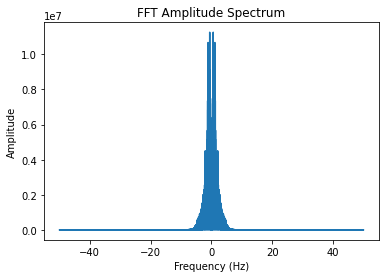

In [6]:
trace = trace_x

# Perform FFT on the trace
trace_data = trace.data
trace_fft = np.fft.fft(trace_data)

# Get frequency values
sampling_rate = trace.stats.sampling_rate
npts = trace.stats.npts
freq = np.fft.fftfreq(npts, d=1.0 / sampling_rate)

# Plot the amplitude spectrum
plt.plot(freq, np.abs(trace_fft))
print(freq)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('FFT Amplitude Spectrum')
plt.show()

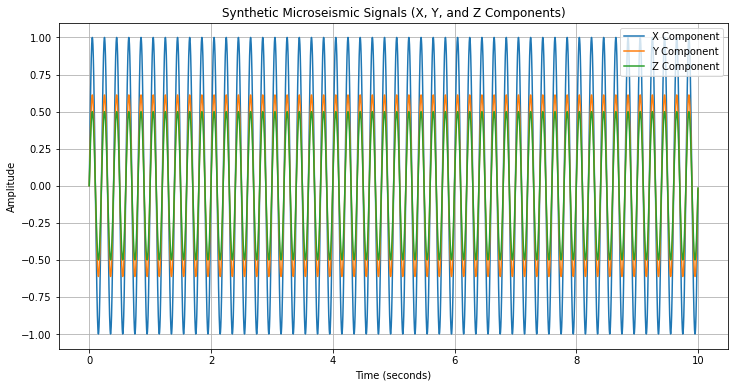

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def generate_microseismic_signal(duration, sampling_rate, frequency, amplitude, azimuth, inclination):
    """
    Generate synthetic microseismic signal in 3 components (X, Y, and Z).

    Parameters:
        duration (float): Duration of the signal in seconds.
        sampling_rate (int): Number of samples per second (sampling frequency).
        frequency (float): Frequency of the microseismic signal in Hz.
        amplitude (float): Amplitude of the microseismic signal.
        azimuth (float): Azimuth angle in degrees (0°: North, 90°: East).
        inclination (float): Inclination angle in degrees (0°: horizontal, 90°: vertical).

    Returns:
        numpy.ndarray: The synthetic microseismic signal in 3 components (X, Y, and Z).
    """
    t = np.linspace(0, duration, int(duration * sampling_rate), endpoint=False)
    rad_azimuth = np.radians(azimuth)
    rad_inclination = np.radians(inclination)

    signal_x = amplitude * np.sin(2 * np.pi * frequency * t)
    signal_y = amplitude * np.cos(rad_azimuth) * np.cos(rad_inclination) * np.sin(2 * np.pi * frequency * t)
    signal_z = amplitude * np.sin(rad_inclination) * np.sin(2 * np.pi * frequency * t)

    return np.array([signal_x, signal_y, signal_z])

# Parameters for synthetic microseismic signal
duration = 10.0  # 10 seconds
sampling_rate = 1000  # 1000 samples per second (1 kHz)
frequency = 5.0  # 5 Hz
amplitude = 1.0  # Amplitude of the signal
azimuth = 45.0  # Azimuth angle in degrees (0°: North, 90°: East)
inclination = 30.0  # Inclination angle in degrees (0°: horizontal, 90°: vertical)

# Generate synthetic microseismic signal in 3 components
microseismic_signal_3d = generate_microseismic_signal(duration, sampling_rate, frequency, amplitude, azimuth, inclination)

# Plot the synthetic microseismic signals in 3 components
t = np.arange(len(microseismic_signal_3d[0])) / sampling_rate
labels = ['X Component', 'Y Component', 'Z Component']

plt.figure(figsize=(12, 6))
for i in range(3):
    plt.plot(t, microseismic_signal_3d[i], label=labels[i])

plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('Synthetic Microseismic Signals (X, Y, and Z Components)')
plt.legend()
plt.grid(True)
plt.show()


In [8]:
def slow_konno_ohmachi(raw_signal,freq_array,smooth_coeff=40,progress_bar=True):
    '''
    NOTE: This is the "ordinary" algorithm where the smoothing window is
          calculated directly. Thus it is slow.
          There is no need to use this function except to test
          the correctness of "fast_konno_ohmachi".

    [Inputs]
        raw_signal: Signal to be smoothed in frequency domain.
        freq_array: Frequency array corresponding to the signal.
                    It must have the same length as "raw_signal".
        smooth_coeff: A parameter determining the degree of smoothing.
                      The lower this parameter, the more the signal
                      is smoothed.
        progress_bar: Whether or not to print a progress bar.

          (Note: "raw_signal" and "freq_array" can be Python lists, 1D numpy
                 arrays, or 2D 1-column/1-row arrays. The data type affects the
                 running time. For optimum speed, use 1D numpy array as input.)
    [Output]
        y: Smoothed signal (1D numpy array).
    '''

    x = raw_signal  # shorten variable names...
    f = freq_array
    f_shifted = f/(1+1e-4)  # shift slightly to avoid numerical errors
    b = float(smooth_coeff)

    if len(x) != len(f):
        print('Length of input signal and frequency array must be the same.')
        sys.exit()

    L = len(x)
    y = np.zeros(L)  # pre-allocation of smoothed signal

    if progress_bar == True:
        progress_bar_width = 40  # width of progress bar (40 characters)
        print('\n|------------    Progress    ------------|') # reference bar
        sys.stdout.write('|')

    # =======  Moving window smoothing: fc from f[1] to f[-2]  ========
    for i in range(L):
        if progress_bar and (np.remainder(i,L/progress_bar_width) == 0):
            sys.stdout.write('|')  # prints "|" without spaces or new lines

        if (i == 0) or (i == L-1):
            continue  # skip first and last indices for now

        fc = f[i]  # central frequency
        w = np.zeros(L)  # pre-allocation of smoothing window "w"

        z = f_shifted / fc  # "z" = dimensionless frequency, normalized by fc
        w = (np.sin(b * np.log10(z)) / b / np.log10(z)) ** 4.0
        w[np.isnan(w)] = 0  # replace NaN's with 0

        y[i] = np.dot(w,x) / np.sum(w)  # apply smoothing filter to "x"

    y[0] = y[1]  # calculate first and last indices
    y[-1] = y[-2]

    if progress_bar:
        sys.stdout.write('|\n')

    return y

In [ ]:
def konno_ohmachi(data, freq, smooth_coeff=40):
    x = data
    f = freq
    f_shif = f/(1+1e-4)
    b = float(smooth_coeff)
    
    L = len(x)
    y = np.zeros(L)
    
    for i in range(L):
        if (i == 0) or (i == L-1):
            continue
        
        fc = f(i)
        w = np.zeros(L)
        z = f_shif/fc
        w = (np.sin(b*np.log10(z))/ b/np.log10(z))**4
        w[np.isnan(w)] = 0
        
        y[i] = np.dot(x,w)/np.sum(w)
    
    y[0] = y[1]
    y[-1] = y[-2]
    
    return y